## Reproduction code for the noisy-data setting

This notebook contains the code for reproducing the numerical results under the noisy-data setting in the paper *Simultaneous activity and attenuation estimation
in TOF-PET with TV-constrained nonconvex
optimization*. In specific, the code in this notebook reproduces Figure 5-8 of the paper.


We start from loading the libraries necessary for running the code.

In [15]:
from numpy import *
import numpy as np
import time
svd = linalg.svd
randn = random.randn
import numba
from numba import njit
from pylab import *
from random import seed
ion()
import scipy
from scipy import ndimage
# Load the test images
testmu = load("./data/UWDRO1_slice40_attenuation.npy")[40:216,40:216]*1.
testlambda = load("./data/UWDRO1_slice40_activity.npy")[40:216,40:216]*1.

1

We set up the system, where the details can be found in `noiseless-setting.ipynb`.

In [2]:
mumask = testmu*0.
mumask[testmu>0.]=1.
totalcounts = 4.0e6 
nx = 176
ny = 176
ximageside = 30.0   
yimageside = 30.0   
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([nx])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
fovmask = testlambda*0.
lambdamask = fovmask*0.
smallmask = testlambda*0.
fovmask[rar<=ximageside/2.] = 1.
lambdamask[rar<=ximageside/4.5] = 1.
smallmask[sqrt((xar-0.)**2 + (yar-5.)**2)<=ximageside/20.] = 1.
mumask = fovmask*1.
flatmask = fovmask.flatten()*1.


radius = 100.0    #cm
detector1_to_detector2 = 200.0   #cm
nviews = 176
slen = pi     
nbins = 176
# The linear detector length is computed in the projection function so that it is
# the exact size needed to capture the projection of the largest inscribed circle in
# the image array.

dtc = dx/16.
ntc = int(detector1_to_detector2/dtc)
tcshift = 0.5*(detector1_to_detector2 - ntc*dtc)
war = arange(radius-detector1_to_detector2+tcshift,radius,dtc)

fwhm = 4.5 #cm

tofspacing = fwhm/2.
toflen = ximageside+2*fwhm
toflen = minimum(toflen,detector1_to_detector2)
tofsig= fwhm/2.355
dtof = tofspacing
ntof = int(toflen/dtof)
toflen = ntof*dtof    #change the toflen so that it is a multiple of dtof
tof0 = -toflen/2.
tofmat = []
for i in range(ntof):
   w0 = (i+0.5)*dtof + tof0
   wfun = exp( -((war-w0)**2)/(2.*tofsig**2))
   tofmat.append(wfun)
tofmat = array(tofmat)


The following are the utility functions for running the algorithms.

In [3]:
## function for forward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamProjection(wimage,sinogram, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   image = mask*wimage
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum
## function for backward projection
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamBackProjection(sinogram, image, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept
   image *= mask


## function for weighted forward projection
@njit(cache=True) # if computing projection multiple times use: @njit(cache=true)
def circularParallelBeamWProjection(image,sinogram, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.


   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensues ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+tofweight2*frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+tofweight2*frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for weighted backward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamWBackProjection(sinogram, image, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen*tofweight2
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen*tofweight2
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               ixOld=ix
               xIntOld=xIntercept

## functions for time-of-flight projection matrix multiplication

def TOFprojection(wimage,tofsino,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   tofsino.fill(0.)
   image = mask*wimage
   for i in range(ntof):
      circularParallelBeamWProjection(image,tofsino[i],tofmat[i])


def TOFbackProjection(tofsino,image,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   image.fill(0.)
   wim = image*0.
   for i in range(ntof):
      circularParallelBeamWBackProjection(tofsino[i],wim,tofmat[i])
      image += wim
   image *= mask

#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad


def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim


def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w


def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w



Next, we generate random count data. The model can be found in `noiseless-setting.ipynb`.

In [4]:
sinogram=zeros([nviews,nbins],"float64")   
sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)

tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)

truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level

tofdata *= datafactor
tofsino *= datafactor
testlambda0  = testlambda * datafactor
truess0 = truess * datafactor
tofdata0 = tofdata*1.0

tofdata = np.random.poisson(tofdata0).astype("float64") # draw the emission data from a poisson distribution

In [7]:
ltofproj,lproj,numu,nulam,ltotmu,ltotlam = np.load("data/stepdata4p5_nulam0p5.npy")
ptvmu = 100
tgx,tgy = gradim(testmu)
tvmu = numu*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvmu/100.0)

ptvlam = 100
tgx,tgy = gradim(testlambda)
tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)
ltotalcounts = testlambda.sum()
ltotalcounts0 = ltotalcounts*1.0

niter = 501 # number of outer loops
newtiter = 10 # number of newton steps
nuv = 100 # number of alternating optimization steps
ntrials = 100 # number of repetitions for computing the standard deviation

We now run ADMM-TVSAA on the noisy data set for 100 iterations.

In [22]:
# output directory
resultsfile = './results/saa_noisy_bothTV_'

# parameters 
tvlamswitch = 1
tvmuswitch = 1
sbmu = 20.0
sblambda = 10.0
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run saa-admm
nims = len(storeiterations)
imagesum = zeros([nims,nx,ny])
imagesos = zeros([nims,nx,ny])
imagemsum = zeros([nims,nx,ny])
imagemsos = zeros([nims,nx,ny])
for nt in range(ntrials):
   print("trial: ",nt)

   tofdata = tofdata0*1.

   tofdata = np.random.poisson(tofdata0).astype("float64") #UNCOMMENT for noise and COMMENT out for no noise
   # normalize again (need to do it this way to allow control over noise)
   newfactor = (fovmask.sum()/tofdata.sum())
   tofdata = tofdata*newfactor
   testlambda  = testlambda0*newfactor
   truess = truess0*newfactor
   ltotalcounts = ltotalcounts0*newfactor

   tgx,tgy = gradim(testlambda)
   tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)

# grid search results 9cm
# Both TV constraints	
   if tvmuswitch and tvlamswitch:
      sbmu = 20.0
      sblambda = 10.0
   else:
      print("didn't tune")
      input("stop")

   sigmu = sbmu/lproj
   taumu = 1.0/(sbmu*lproj)

   siglambda = sblambda/ltofproj
   taulambda = 1.0/(sblambda*ltofproj)

   worktofsino = 0.*tofsino
   ulambda = 0.*tofsino
   ylambda = 0.*tofsino

   imlambda = testlambda*0.
   wimlambda = testlambda*0.
   ugradlamx = testlambda*0.
   ygradlamx = testlambda*0.
   ugradlamy = testlambda*0.
   ygradlamy = testlambda*0.

   worksino = 0.*sinoatt
   umu = 0.*sinoatt
   ymu = 0.*sinoatt
   ugradmux = testlambda*0.
   ygradmux = testlambda*0.
   ugradmuy = testlambda*0.
   ygradmuy = testlambda*0.

   immu = testmu*0.
   wimmu = testmu*0.



   nim = 0
   for j in range(niter):
# x-update
      TOFprojection(imlambda,worktofsino)
      arg1 = ulambda+siglambda*(worktofsino -ylambda)
      TOFbackProjection(arg1,wimlambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam

      argx = ugradlamx + siglambda*(tgx - ygradlamx)
      argy = ugradlamy + siglambda*(tgy - ygradlamy)
      wgradimlam = mdiv(argx,argy)
      wgradimlam *= nulam*fovmask
      tvlamest  = sqrt(tgx**2 + tgy**2).sum()

      tempvex =(imlambda -taulambda*(wimlambda +wgradimlam )).flatten()
      tempvex2 = tempvex[flatmask>0.5]
      resvex = euclidean_proj_simplex(tempvex2, s=ltotalcounts)
      tempvex[flatmask>0.5] = resvex*1.
      tempvex.shape = nx,ny
      imlambda = tempvex*1.


      TOFprojection(imlambda,worktofsino)
      workgradlamx, workgradlamy = gradim(imlambda)
      workgradlamx *= nulam
      workgradlamy *= nulam

      circularParallelBeamProjection(immu,worksino)
      arg1 = umu +sigmu*( worksino -ymu )
      circularParallelBeamBackProjection(arg1,wimmu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      argx = ugradmux + sigmu*(tgx - ygradmux)
      argy = ugradmuy + sigmu*(tgy - ygradmuy)
      wgradimmu = mdiv(argx,argy)
      wgradimmu *= numu*fovmask

      immu =immu - wimmu*taumu - wgradimmu*taumu
      immu[immu<0.]=0.
      immu *= mumask
      circularParallelBeamProjection(immu,worksino)
      workgradmux, workgradmuy = gradim(immu)
      workgradmux *= numu
      workgradmuy *= numu

      tvmuest  = sqrt(tgx**2 + tgy**2).sum()

      ylambdat = 1.*ylambda
      ymut = 1.*ymu
# y-update
      aq = siglambda
      cq = -tofdata
      hessmin = 1.e10
      for k in range(nuv):
         ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
         bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
         ylambdaold = ylambda*1.
         ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
         ylambdaold = ylambda*1.

         ymunewt = ymu*0.
         for i in range(newtiter):
            grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*exp(-ymunewt)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
            ymunewt[ymunewt<0.] = 0.
         ymuold = ymu*1.
         ymumin = ymunewt.min()
         ymu = ymunewt*1.
         ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
         ymudist = sqrt( ( (ymu-ymuold)**2).sum())

      ptilx= ugradlamx/siglambda + workgradlamx
      ptily= ugradlamy/siglambda + workgradlamy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvlamswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradlamx = ptilx*1.
      ygradlamy = ptily*1.

      ptilx= ugradmux/sigmu + workgradmux
      ptily= ugradmuy/sigmu + workgradmuy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvmuswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradmux = ptilx*1.
      ygradmuy = ptily*1.
   
# u-update
#   input("hi")
      TOFprojection(imlambda,worktofsino)
      ulambda = ulambda + siglambda*(worktofsino - ylambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam
      ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
      ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

      circularParallelBeamProjection(immu,worksino)
      umu = umu +sigmu*(worksino-ymu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      ugradmux = ugradmux + sigmu*(tgx - ygradmux)
      ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


      attfactorest = exp(-worksino)
      datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
      datarmse2 = sqrt(( (tofdata-worktofsino*exp(-worksino))**2. ).sum())/sqrt(1.*ntof*nviews*nbins)
      imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
      imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
      attdiff = (truess)*(attfactor -  attfactorest)
      attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )

      if j+1 in storeiterations:
         print("iter: ",j," ",datarmse2," ",imagelrmse," ",imagemrmse," ",attrmse)
         print("TV lam: ",tvlamest,":",tvlambda," TV mu: ",tvmuest,":",tvmu)
         imagesum[nim] += (imlambda/newfactor)
         imagesos[nim] += (imlambda/newfactor)**2
         imagemsum[nim] += immu
         imagemsos[nim] += immu**2
         nim += 1

for i in range(nims):
   ilmean = imagesum/ntrials
   stdiff =  imagesos - (imagesum**2.)/ntrials
   stdiff[stdiff < 0.] = 0.
   ilstd = sqrt( stdiff/(ntrials-1.) )

   immean = imagemsum/ntrials
   stmdiff =  imagemsos - (imagemsum**2.)/ntrials
   stmdiff[stmdiff < 0.] = 0.
   imstd = sqrt( stmdiff/(ntrials-1.) )

batch = nt % 10
save(resultsfile+"lambdamean_TVmu100_TVlam100_batch" + str(batch) + ".npy",ilmean/datafactor)
save(resultsfile+"lambdastd_TVmu100_TVlam100_batch" + str(batch) + ".npy",ilstd/datafactor)
save(resultsfile+"mumean.npy_TVmu100_TVlam100_batch" + str(batch) + ".npy",immean)
save(resultsfile+"mustd.npy_TVmu100_TVlam100_batch" + str(batch) + ".npy",imstd)


SyntaxError: unterminated string literal (detected at line 257) (2786897107.py, line 257)

We now reproduce Figure 5.

[5, 10, 20, 50, 100, 200, 500]
[5, 10, 20, 50, 100, 200, 500]


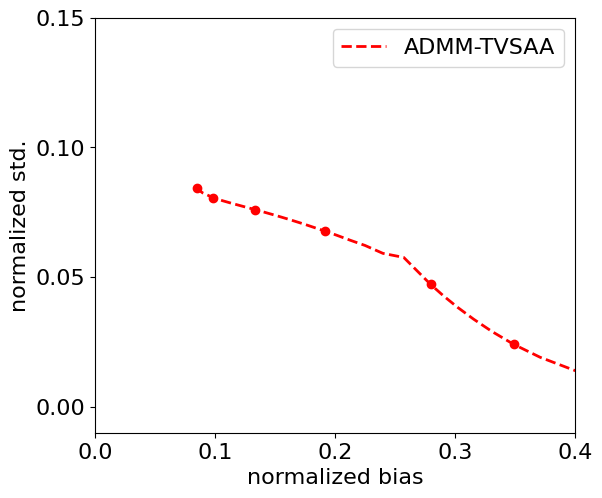

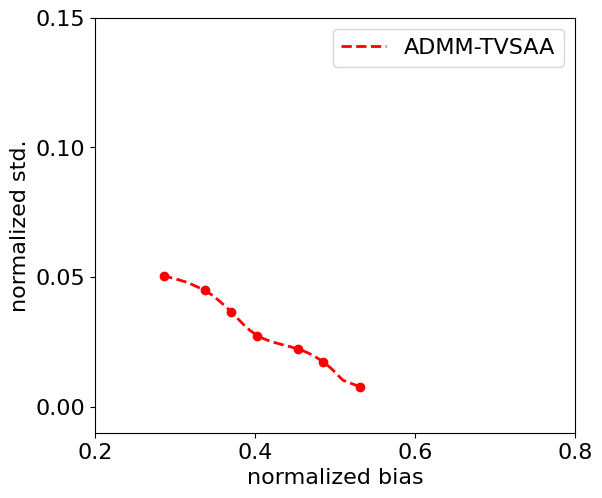

In [23]:
from pylab import *
ion()
imlam0 = load("./data//UWDRO1_slice40_activity.npy")[40:216,40:216]*1.
immu0 = load("./data/UWDRO1_slice40_attenuation.npy")[40:216,40:216]*1.
#im0 *= 1.e6/im0.sum()


storeiterations=[1,2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,120,140,160,180,200,300,400,500]
storeiterations=array(storeiterations)
subiter = [1,4,7,12,18,23,28,31]
subiterz = [1,4,7,12,18,23]
subiter = [4,7,12,18,23,28,31]
subiterz = [4,7,12,18,23]


for batch in range(10):
   batchstr = "_batch"+str(batch)
   im1 = np.load("results/lambdamean_TVmu100_TVlam100"+batchstr+".npy")
   istd1 = np.load("results/lambdastd_TVmu100_TVlam100"+batchstr+".npy")
   immu1 = np.load("results/mumean_TVmu100_TVlam100"+batchstr+".npy")
   imustd1 = np.load("results/mustd_TVmu100_TVlam100"+batchstr+".npy")
   im1sumb = im1*10.
   im1sosb = 9.*istd1**2 +(im1sumb**2.)/10.
   immu1sumb = immu1*10.
   immu1sosb = 9.*imustd1**2 +(immu1sumb**2.)/10.
   immusumb = immu*10.
   if batch==0:
      im1sum = im1sumb*1.
      im1sos = im1sosb*1.
      immu1sum = immu1sumb*1.
      immu1sos = immu1sosb*1.
      immusum = immusumb*1.
   else:
      im1sum += im1sumb*1.
      im1sos += im1sosb*1.
      immu1sum += immu1sumb*1.
      immu1sos += immu1sosb*1.
      immusum += immusumb*1.

ntrials = 100
stdiff[stdiff < 0.] = 0.
istd = sqrt( stdiff/(ntrials-1.) )
immu = immusum/ntrials
stdiff[stdiff < 0.] = 0.
imustd = sqrt( stdiff/(ntrials-1.) )

im1 = im1sum/ntrials
stdiff =  im1sos - (im1sum**2.)/ntrials
stdiff[stdiff < 0.] = 0.
istd1 = sqrt( stdiff/(ntrials-1.) )
immu1 = immu1sum/ntrials
stdiff =  immu1sos - (immu1sum**2.)/ntrials
stdiff[stdiff < 0.] = 0.
imustd1 = sqrt( stdiff/(ntrials-1.) )


data1 = []
for i in range(len(im1)):
   nmean = sqrt( ((im1[i]-imlam0)**2).sum() )/sqrt( (imlam0**2).sum() )
   nstd =  sqrt((istd1[i]**2).sum()) /sqrt( (imlam0**2).sum() )
   data1.append([nmean,nstd])


data1 = array(data1)



#print("hope this is 500: ",storeiterations[31])
np.save("./results/admmtv_lam500mean.npy",im1[31])
#np.save("mlaahu_lam500mean.npy",im[31])

figure(1,figsize=(6,5))

subdata1 =data1[subiter]
plot(subdata1[:,0],subdata1[:,1],'ro')

data1 = data1[4:]

plot(data1[:,0],data1[:,1],'r--',linewidth=2.0,label="ADMM-TVSAA")

legend(loc="best",fontsize=16)



xlabel("normalized bias",fontsize=16)
xticks([0.,0.1,0.2,0.3,0.4],fontsize=16)

ylabel("normalized std.",fontsize=16)
yticks([0.0,0.05,0.1,0.15],fontsize=16)

piter = storeiterations[subiter].tolist()
print(piter)


axis([0.0,0.4,-0.01,0.15])

subplots_adjust(left= 0.15,bottom= 0.12,top=0.95,right=0.95)

#savefig("figs/lam_bias_std_nolabel.png",dpi=300)

data1 = []
for i in range(len(immu1)):
   nmean = sqrt( ((immu1[i]-immu0)**2).sum() )/sqrt( (immu0**2).sum() )
   nstd =  sqrt((imustd1[i]**2).sum()) /sqrt( (immu0**2).sum() )
   data1.append([nmean,nstd])


data1 = array(data1)

#data = array(data)#[:7]
#dataz = array(dataz)[:-8]

#print("hope this is 500: ",storeiterations[31])
np.save("./results/admmtv_mu500mean.npy",immu1[31])
#np.save("mlaahu_mu500mean.npy",immu[31])

figure(2,figsize=(6,5))
subdata1 =data1[subiter]
plot(subdata1[:,0],subdata1[:,1],'ro')

data1 = data1[4:]

plot(data1[:,0],data1[:,1],'r--',linewidth=2.0,label="ADMM-TVSAA")

legend(loc="best",fontsize=16)



xlabel("normalized bias",fontsize=16)
xticks([0.2,0.4,0.6,0.8],fontsize=16)

ylabel("normalized std.",fontsize=16)
yticks([0,0.05,0.1,0.15],fontsize=16)

piter = storeiterations[subiter].tolist()
print(piter)


axis([0.2,0.8,-0.01,0.15])

subplots_adjust(left= 0.15,bottom= 0.12,top=0.95,right=0.95)

#savefig("figs/mu_bias_std_nolabel.png",dpi=300)


The following code reproduces Figure 6.

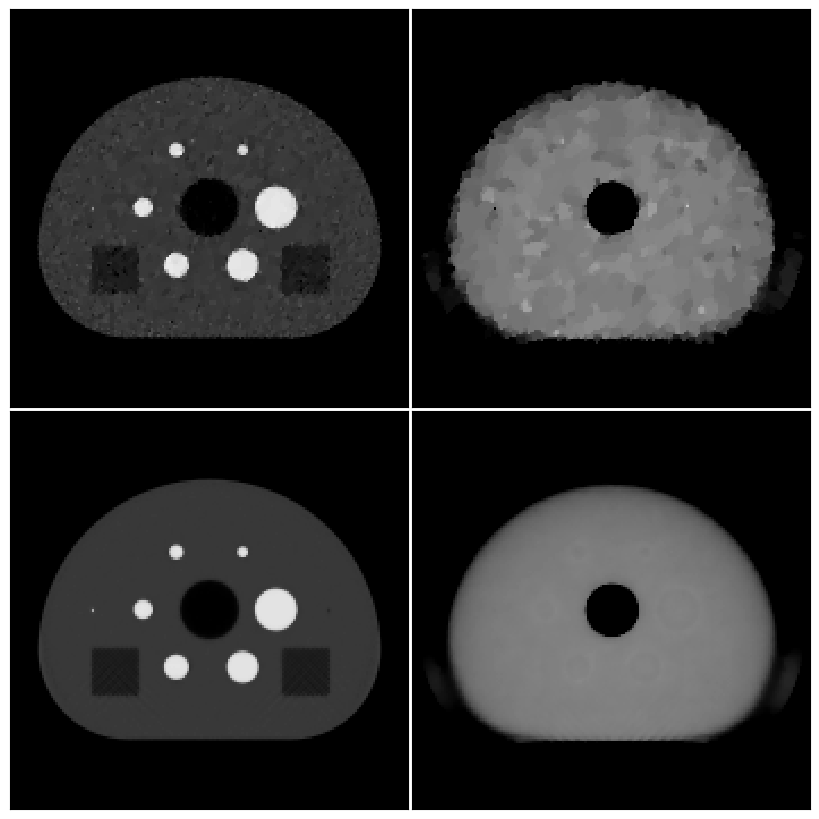

In [24]:
from pylab import *
ion()

lammean = np.load("./results/admmtv_lam500mean.npy")/32768.
mumean = np.load("./results/admmtv_mu500mean.npy")
lam3 = np.load("results/lambda_500_TVmu100_TVlam100.npy")/32768.
mu3 = np.load("results/mu_500_TVmu100_TVlam100.npy")

vmm1= 0.0
vmx1= 1.1
vmm2= 0.055
vmx2= 0.135
figure(1,figsize=(8,8))
subplot(221)
imshow(lam3,vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(222)
imshow(mu3,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(223)
imshow(lammean,vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(224)
imshow(mumean,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplots_adjust(left = 0.0, bottom = 0.0,top = 1,right= 1,hspace =0.01,wspace = 0.01)


The following code reproduces Figure 8.

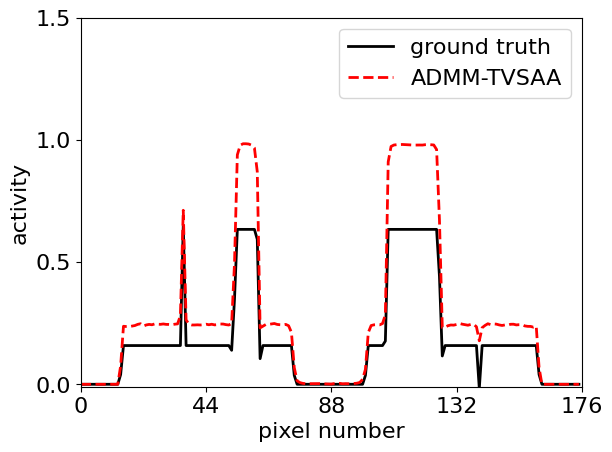

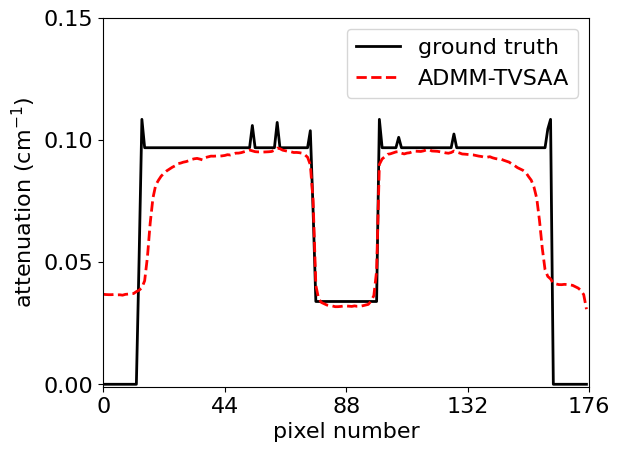

In [25]:
lamtvmean = np.load("./results/admmtv_lam500mean.npy")/32768.
mutvmean = np.load("./results/admmtv_mu500mean.npy")

figure(1,figsize=(6,4.5))
plot(testlambda[88],'k-',linewidth=2.0,label="ground truth")
plot(lamtvmean[88],'r--',linewidth=2.0,label="ADMM-TVSAA")
xticks([0,44,88,132,176],fontsize=16)
yticks([0,0.5,1.0,1.5],fontsize=16)
axis([0,176,-0.01,1.5])
ylabel("activity",fontsize=16)
xlabel("pixel number",fontsize=16)
legend(loc="best",fontsize=16)
subplots_adjust(left=0.125,bottom=0.15,top = 0.97,right =0.96)



figure(2,figsize=(6,4.5))
plot(testmu[88],'k-',linewidth=2.0,label="ground truth")
plot(mutvmean[88],'r--',linewidth=2.0,label="ADMM-TVSAA")
xticks([0,44,88,132,176],fontsize=16)
yticks([0,0.05,0.1,0.15],fontsize=16)
axis([0,176,-0.001,0.15])
ylabel(r"attenuation (cm$^{-1}$)",fontsize=16)
xlabel("pixel number",fontsize=16)
legend(loc="best",fontsize=16)
subplots_adjust(left=0.15,bottom=0.15,top = 0.97,right =0.96)


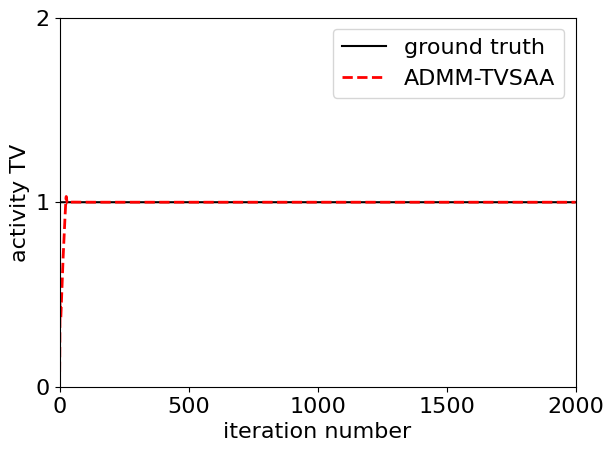

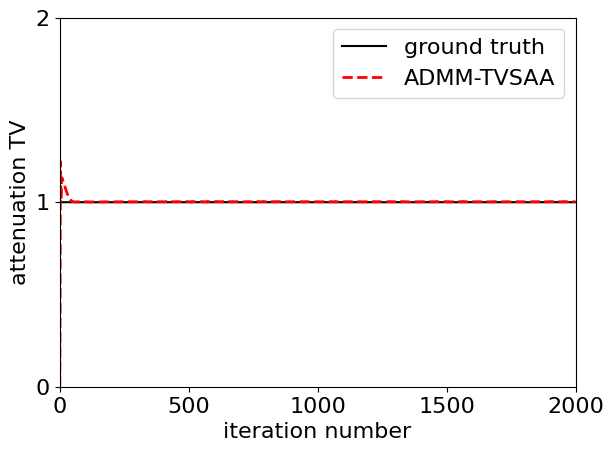

In [29]:
lamadmmtv = np.load("results/tvlambda_TVmu100_TVlam100.npy")
lamtruth = lamadmmtv*0. +1.

figure(1,figsize=(6,4.5))

plot(lamtruth,"k-",linewidth=1.5,label = "ground truth")
plot(lamadmmtv,"r--",linewidth=2.0,label = "ADMM-TVSAA")
axis([0,2000,0.0,2.0])

legend(loc="best",fontsize=16)
xticks([0,500,1000,1500,2000],fontsize=16)
yticks([0,1,2],fontsize=16)
xlabel("iteration number",fontsize=16)
ylabel("activity TV", fontsize=16)
subplots_adjust(left=0.09,bottom=0.13,top=0.95,right= 0.95)

lamadmmtv = np.load("results/tvmu_TVmu100_TVlam100.npy")
lamtruth = lamadmmtv*0. +1.

figure(2,figsize=(6,4.5))

plot(lamtruth,"k-",linewidth=1.5,label = "ground truth")
plot(lamadmmtv,"r--",linewidth=2.0,label = "ADMM-TVSAA")
axis([0,2000,0.0,2.0])

legend(loc="best",fontsize=16)
xticks([0,500,1000,1500,2000],fontsize=16)
yticks([0,1,2],fontsize=16)
xlabel("iteration number",fontsize=16)
ylabel("attenuation TV", fontsize=16)
subplots_adjust(left=0.09,bottom=0.13,top=0.95,right= 0.95)